In [1]:
# sys, file and nav packages:
import datetime as dt

# math packages:
import pandas as pd
import numpy as np
import math

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
import seaborn as sns

# home brew utitilties
import resources.chart_kwargs as ck
import resources.sr_ut as sut

# images and display
from PIL import Image as PILImage
from IPython.display import Markdown as md
from IPython.display import display

# set some parameters:
today = dt.datetime.now().date().strftime("%Y-%m-%d")
start_date = '2020-03-01'
end_date ='2021-05-31'

fail_rate = 50
unit_label= 'pcs_m'

# the city, lake and river bassin we are aggregating to
# the keys are column names in the survey data
levels = {"city":"Biel/Bienne","water_name_slug":'bielersee', "river_bassin":'aare'}
level_names = [levels['city'], "Bielersee","Aare survey area"]
top = "All survey areas"

# colors for gradients
cmap2 = ck.cmap2
colors_palette = ck.colors_palette

(keyindicators)=
# Key statistical indicators

<a href="key_indicators_de.html"> Deutsch </a>

Easy to calculate and taken directly from the survey results the key indicators are essential to identifying zones of accumulation within the watershed. When used in the context of a litter monitoring program and combined with specific knowledge of the surrounding area the key indicators help identify potential sources of litter. {cite}`mlwguidance`

Assessments of beach-litter surveys describe the location, abundance and composition of the objects found {cite}`eubaselines`. The key indicators answer the following questions: 

* What items are found? 
* How much is found? (total weights and item counts) 
* How often are these items found? 
* Where are these items found in the greatest concentrations? 
   
Similar to counting birds or wildflowers a litter-surveyor has to find the quarry and then identify it, this process is well documented and has been tested under many conditions{cite}`ryan2015` {cite}`Rech`.

__Indicators for the most frequent questions__

The key indicators provide answers to the most frequent questions about the state of litter in the natural environment. The key indicators are:

1. number of samples
2. pass-fail rate (fail-rate)
3. number of objects per meter (pcs/m or pcs/m²)
4. composition (% of total)

__Assumptions of the key indicators:__

The reliability of these indicators is based on the following assumptions:

1. The more trash there is on the ground the more a person is likely to find
2. The survey results represent the minimum amount of trash at that site
3. The surveyors are following the protocol and recording findings accurately
4. For each survey: finding one item does not effect the chance of finding another {cite}`iid`

__Using the key indicators__

The key indicators of the most common objects are given with every data summary at each aggregation level. If the previous assumptions are maintained then the number of samples in the region of interest should always be considered as a measure of uncertainty. The more samples that there are within defined geographic and temporal bounds the more confidence can be had in the numerical results that are obtained from surveys within those bounds.

## Definition: the most common objects

_The most common objects are those objects that have a fail rate greater than or equal to 50% and/or are in the top-ten by quantity or pieces/m for any defined geographic area._

In [2]:
# get your data:
survey_data = pd.read_csv('resources/checked_sdata_eos_2020_21.csv')
# river_bassins = ut.json_file_get("resources/river_basins.json")
dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
dfCodes = pd.read_csv("resources/codes_with_group_names_2015.csv")
dfDims = pd.read_csv("resources/corrected_dims.csv")

# set the index of the beach data to location slug
dfBeaches.set_index('slug', inplace=True)

city_map = dfBeaches['city']

dfCodes.set_index("code", inplace=True)

codes_to_change = [
    ["G74", "description", "Insulation foams"],
    ["G940", "description", "Foamed EVA for crafts and sports"],
    ["G96", "description", "Sanitary-pads/tampons, applicators"],
    ["G178", "description", "Metal bottle caps and lids"],
    ["G82", "description", "Expanded foams 2.5cm - 50cm"],
    ["G81", "description", "Expanded foams .5cm - 2.5cm"],
    ["G117", "description", "Expanded foams < 5mm"],
    ["G75", "description", "Plastic/foamed polystyrene 0 - 2.5cm"],
    ["G76", "description", "Plastic/foamed polystyrene 2.5cm - 50cm"],
    ["G24", "description", "Plastic lid rings"],
    ["G33", "description", "Lids for togo drinks plastic"],
    ["G3", "description", "Plastic bags, carier bags"],
    ["G204", "description", "Bricks, pipes not plastic"],
    ["G904", "description", "Plastic fireworks"],
    ["G211", "description", "Swabs, bandaging, medical"],
]

for x in codes_to_change:
    dfCodes = sut.shorten_the_value(x, dfCodes)
    
# make a map to the code descriptions
code_description_map = dfCodes.description

# make a map to the code descriptions
code_material_map = dfCodes.material

## The key indicators

*__Below:__ Aare survey area, map of survey locations.* 

In [3]:
dfSurveys = sut.fo_rmat_and_slice_date(survey_data.copy(), a_format="%Y-%m-%d", start_date=start_date, end_date=end_date)

trb = dfSurveys[dfSurveys.river_bassin == levels['river_bassin']].copy()

# describe the data set:
num_obs = len(trb)
num_samps = len(trb.loc_date.unique())
num_obj = trb.quantity.sum()
num_locs = len(trb.location.unique())

# the city that we are looking at:
biel = trb[trb.city == levels['city']]

# samples at biel
biel_locd = biel.loc_date.unique()

# locations at biel
biel_loc = biel.location.unique()

# example data summary and keys
biel_t = biel.quantity.sum()

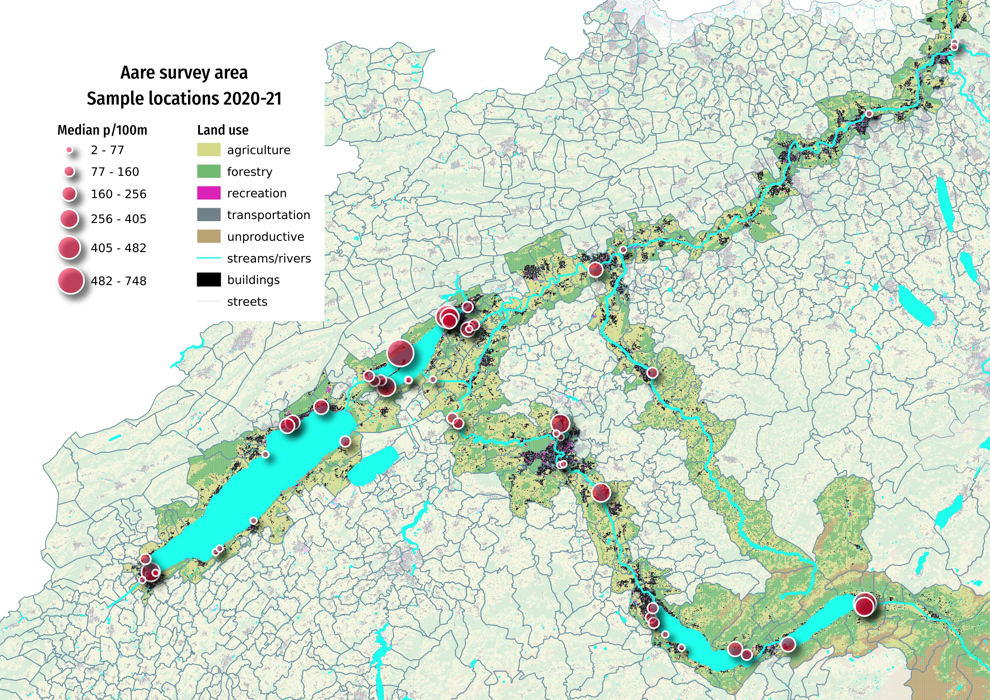

In [4]:
sut.display_image_ipython("resources/maps/survey_areas/aare_scaled.jpeg", thumb=(1200, 700))

In [5]:
md(F"\n\nThere were {'{:,}'.format(num_obj)} objects collected from {num_samps} surveys in the Aare survey area between 2020-03-01 and 2020-05-31.\n")



There were 13,847 objects collected from 140 surveys in the Aare survey area between 2020-03-01 and 2020-05-31.


*__Below:__ The survey results of the Aare survey area, with detail of Biel/Bienne and monthly median. __Botton left:__ Summary statisitics for the Aare Survey area. __Bottom right:__ Summary statistics Biel/Bienne.*

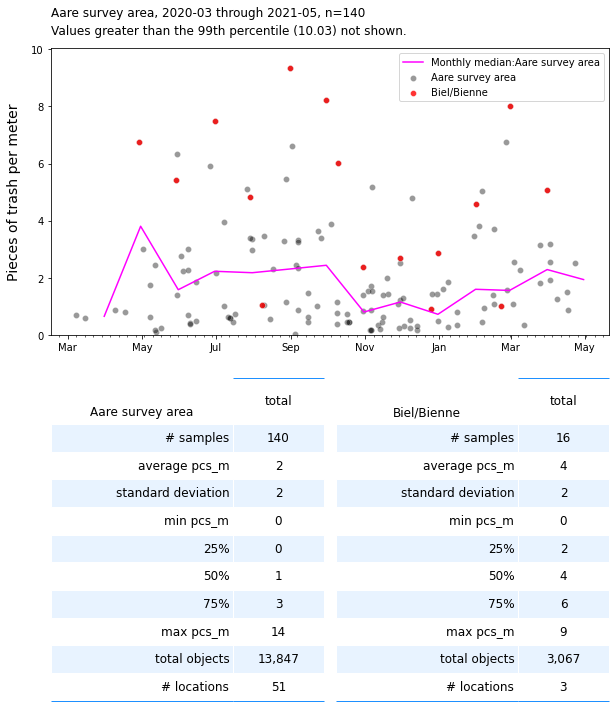

In [6]:
# select data
data = trb.groupby(['loc_date','location',  'date'], as_index=False).agg({'pcs_m':'sum', 'quantity':'sum'})

# get the basic statistics from pd.describe
d_aare = data['pcs_m'].describe().round(2)

# add project totals
d_aare['total objects'] = data.quantity.sum()
d_aare['# locations'] = data.location.nunique()

# format table one
aare_table = sut.change_series_index_labels(d_aare, sut.create_summary_table_index(unit_label, lang="EN"))
table_one = sut.fmt_combined_summary(aare_table, nf=[])

# select data
db = biel.groupby(['loc_date','location',  'date'], as_index=False).agg({'pcs_m':'sum', 'quantity':'sum'})

# get the basic statistics from pd.describe
d_biel = db['pcs_m'].describe().round(2)

# add project totals
d_biel['total objects'] = db.quantity.sum()
d_biel['# locations'] = db.location.nunique()

# format table two
biel_table = sut.change_series_index_labels(d_biel, sut.create_summary_table_index(unit_label, lang="EN"))
table_two = sut.fmt_combined_summary(biel_table, nf=[])

# # format for time series
months_fmt = mdates.DateFormatter('%b')
days = mdates.DayLocator(interval=7)

# # get the data
dt_all = trb.groupby(['loc_date', 'date'], as_index=False).pcs_m.sum()
bt_all = biel.groupby(['loc_date', 'date'], as_index=False).pcs_m.sum()
monthly_plot = dt_all.set_index('date', drop=True).pcs_m.resample('M').median()

# chart that
fig = plt.figure(figsize=(10, 12))

spec = GridSpec(ncols=8, nrows=18, figure=fig)
axone = fig.add_subplot(spec[0:8,:])
axtwo = fig.add_subplot(spec[9:,0:4])
axthree = fig.add_subplot(spec[9:,4:8])

sns.scatterplot(data=dt_all, x='date', y='pcs_m', color='black', alpha=0.4, label="Aare survey area", ax=axone)
sns.scatterplot(data=bt_all, x='date', y='pcs_m', color='red', alpha=0.8, label="Biel/Bienne", ax=axone)
sns.lineplot(data=monthly_plot, x=monthly_plot.index, y=monthly_plot, color='magenta', label=F"Monthly median:{level_names[2]}", ax=axone)

the_90th = np.percentile(dt_all.pcs_m, 99)

not_included = F"Values greater than the 99th percentile ({round(the_90th, 2)}) not shown."

axone.set_ylabel("Pieces of trash per meter", **ck.xlab_k14)
axone.set_ylim(0,the_90th )
axone.set_title(F"{level_names[2]}, {start_date[:7]} through {end_date[:7]}, n={num_samps}\n{not_included}",  **ck.title_k)
axone.xaxis.set_minor_locator(days)
axone.xaxis.set_major_formatter(months_fmt)
axone.set_xlabel("")

axtwo.set_xlabel(" ")
sut.hide_spines_ticks_grids(axtwo)

a_col = ['Aare survey area', 'total']
table1 = sut.make_a_table(axtwo, table_one,  colLabels=a_col, colWidths=[.5,.25,.25],  bbox=[0,0,1,1], **{"loc":"lower center"})

axthree.set_xlabel(" ")
sut.hide_spines_ticks_grids(axthree)
a_col = ["Biel/Bienne", "total"]
table2 = sut.make_a_table(axthree, table_two,  colLabels=a_col, colWidths=[.5,.25,.25],  bbox=[0,0,1,1], **{"loc":"lower center"})

plt.show()

### The number of samples

The number of samples refers to the number of samples within a geographic and temporal range. As stated previously, the more samples there are within a specified area and date range the more confidence can be placed on the results of the analysis.

### The fail-rate

The fail rate is the number of times that an object was found at least once divided by the number of surveys. 

**What does it mean?** The fail rate describes the percent of times that a category **was** identified in relation to the amount of surveys conducted.

> Use the fail rate to determine how frequently an object was found within a geographic range. Items can be differentiated by the fail rate. Use the fail rate and pcs/m to identify objects that are found infrequently but in important quantities.

__Different fail rates at different levels__

The fail rate is calculated at each aggregation level. As a result the fail rate for any particular object will change depending on the geographic bounds that define the aggregation level. Consider all the objects that were found in at least 1/2 surveys in the Aare survey area.

*__Below:__ The fail rates of the most common items from the Aare survey area at different aggreagtion levels.*

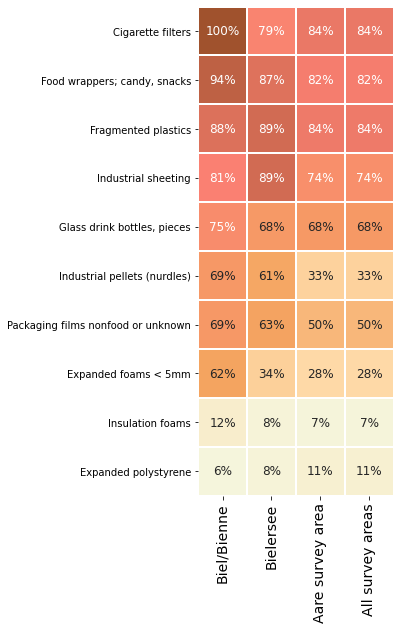

In [7]:
# identify the most common and the most abundant objects in the river bassin
trb_mc = trb.groupby(['loc_date','code'], as_index=False).agg({'fail':'sum', 'quantity':'sum', unit_label:'sum'})
trb_mcom = trb_mc.groupby('code', as_index=False).agg({'fail':'sum', 'quantity':'sum', unit_label:'median'})

# get the fail rate and separate the data into most common and most abundant
trb_mcom['f_r'] = trb_mcom.fail/trb.loc_date.nunique()

# most common
trb_grt50 = trb_mcom[trb_mcom.f_r >= fail_rate]

# most abundant
trb_pcs = trb_mcom.sort_values(by='quantity', ascending=False)

# codes from each
c_grt50 = trb_grt50.code.unique()
c_qty = trb_pcs.code.unique()[:10]

# joint list
thecommon = list(set(c_grt50) | set(c_qty))

biel_fail = biel[biel.code.isin(thecommon)].groupby('code', as_index=False).fail.sum()
biel_fail['rate'] = biel_fail.fail/biel.loc_date.nunique()
bf = biel_fail.sort_values(by='rate', ascending=False)
m_common = bf.copy()

m_common['label'] = 'Biel/Bienne'

# pivot that
mcp = m_common[['code', 'rate', 'label']].pivot(columns='label', index='code')

# quash the hierarchal column index
mcp.columns = mcp.columns.get_level_values(1)

def get_fail_rate(trb, obj="code", thecommon=[], level="water_name_slug", level_name=[]):
    f = trb[(trb[obj].isin(thecommon ))&(trb[level].isin(level_name))]
    tries = f.loc_date.nunique()
    fails = f.groupby(obj).fail.sum()
    return fails/tries

mcp[level_names[1]] = get_fail_rate(trb, obj="code", thecommon=thecommon, level="water_name_slug", level_name=["bielersee"])
mcp[level_names[2]] = get_fail_rate(trb, thecommon=thecommon, level="river_bassin", level_name=["aare"])
mcp[top] = get_fail_rate(trb, thecommon=thecommon, level="river_bassin", level_name=["aare", "linth", "rhone", "ticino"])

mcp["item"] = mcp.index.map(lambda x: code_description_map[x])
mcp = mcp.set_index("item").sort_values(by="Biel/Bienne", ascending=False)

# chart that
fig, ax  = plt.subplots(figsize=(len(mcp.columns)*.9,len(mcp)*.9))
axone = ax

sns.heatmap(mcp, ax=axone, cmap=cmap2, annot=True, annot_kws={"fontsize":12}, fmt=".0%", square=True, cbar=False, linewidth=.1, linecolor='white')

axone.set_xlabel("")
axone.set_ylabel("")
axone.tick_params(labelsize=10, which='both', axis='y')
axone.tick_params(labelsize=14, which='both', axis='x')

plt.setp(axone.get_xticklabels(), rotation=90)

plt.show()
plt.close()

With the exception of industrial sheeting and fragmented plastics the fail rate was greater in Biel/Bienne than all other survey areas. This means that on a per survey basis there was a greater chance of finding those objects at Biel/Bienne than most other places.

The pass-fail rate is the  most likely estimate (MLE) of the probability of finding at least one object {cite}`mle`. If the object was identified in all previous samples and there has been no changes in attenuation of prevention measures it is reasonable to assume that there will be at least one in the proceeding samples.

__Note:__ the fail rate gives no indication of quantity.

### Pieces per meter 

Pieces per meter (pcs/m) is the number of objects found at each survey divided by the length of the shoreline surveyed.

**What does it mean?** pcs/m describes the quantity of an object that was found for each meter of shoreline surveyed. It is a method of normalizing the data from all surveys so that it may be compared. 

> Use pieces per meter to find the objects that were found in the greatest quantities. Use pieces per meter to identify zones of accumulation.

_Why not use the surface area?_ The recommended EU standard is to report the results as quantity of objects per length of shoreline surveyed, usually 100 meters {cite}`eubaselines`. The surface area was calculated for 99% of all surveys in IQAASL. The results for this analysis are reported in pcs/m.

*__Below:__ Aare survey area: the median pcs/m of the most common objects*  

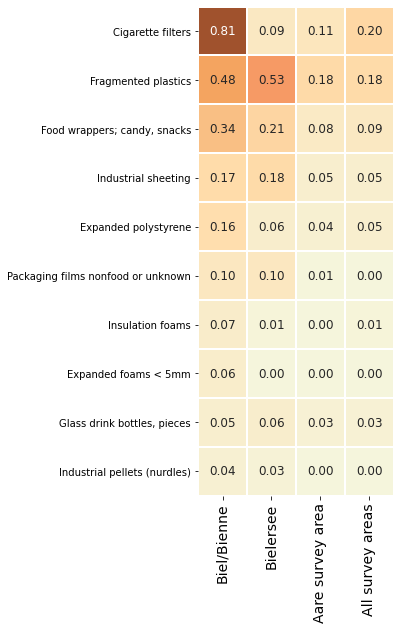

In [8]:
# aggregated survey totals for the most common codes for all the water features
# a common aggregation
agg_pcs_quantity = {unit_label:'sum', 'quantity':'sum'}

m_common_st = biel[biel.code.isin(thecommon)].copy()

m_c = m_common_st.groupby(['code'], as_index=False)[unit_label].median()

m_c = m_c.sort_values(by=unit_label, ascending=False)
m_c.rename(columns={unit_label:level_names[0]}, inplace=True)
m_c.set_index("code", inplace=True)

# for the lake
condition = (trb.code.isin(thecommon))&(trb.water_name_slug == 'bielersee')
m_c[level_names[1]]= sut.aggregate_to_group_name(trb[condition], unit_label=unit_label, column="code", name= level_names[1], val="med")

# for the survey area
condition = (trb.code.isin(thecommon))&(trb.river_bassin == levels["river_bassin"])
m_c[level_names[2]]= sut.aggregate_to_group_name(trb[condition], unit_label=unit_label, column="code", name= level_names[2], val="med")

# for all the data
m_c[top] = sut.aggregate_to_group_name(dfSurveys,column="code", unit_label=unit_label, name=top, val="med")

m_c["item"] = m_c.index.map(lambda x: code_description_map[x])
m_c.set_index("item", drop=True, inplace=True)

# chart that
fig, ax  = plt.subplots(figsize=(len(m_c.columns)*.9,len(m_c)*.9))

axone = ax

sns.heatmap(m_c, ax=axone, cmap=cmap2, annot=True, annot_kws={"fontsize":12}, fmt=".2f", square=True, cbar=False, linewidth=.1, linecolor='white')

axone.set_ylabel("")
axone.tick_params(labelsize=10, which='both', axis='y')
axone.tick_params(labelsize=14, which='both', axis='x')

plt.setp(axone.get_xticklabels(), rotation=90)

plt.show()
plt.close()

The reported value is the median survey result for that aggregation level and object. A median value of zero means that the object was identified in less than 1/2 surveys for that aggregation level. For example, consider the results for _insulation: includes spray foams_. The median value for the Aare survey area is zero however, when just the results of Bielersee or Biel/Bienne are considered the median value is greater than zero. Suggesting that insulation was found at greater rates on Bielersee and specifically in Biel/Bienne than the rest of the Aare survey area.

#### Percent of total

The percent of total is the amount of an object found divided by the total amount of all objects found for a defined location/region and date range.

**What does it mean?** The percent of total describes the composition of the trash found.

> Use the percent of total to define the principal trash objects. Use percent of total to identify priorities on a regional scale

Similar to pieces per meter, if an object has a low pass-fail rate and an elevated % of total it is a signal that objects are possibly being deposited in large quantities at irregular intervals: dumping or accidents.

In [9]:
ac = biel[biel.code.isin(thecommon)].groupby('code', as_index=False).quantity.sum()
accounted_total = ac.quantity.sum()
ac.sort_values(by='quantity', ascending=False, inplace=True)

bsee = ac.copy()
bsee['pt'] = ac.quantity/biel.quantity.sum()
these_codes = bsee.sort_values(by='pt', ascending=False).code.unique()
bsee.sort_values(by='pt', ascending=False, inplace=True)
# bsee['item'] = bsee.code.map(lambda x: code_description_map.loc[x])
# bsee.set_index('item', inplace=True)
bsee[level_names[0]] = bsee['pt']
bsee = bsee[["code", level_names[0]]]
bsee.set_index("code", inplace=True, drop=True )


# for the lake
condition = (trb.code.isin(thecommon))&(trb.water_name_slug == 'bielersee')
bsee[level_names[1]]= sut.aggregate_to_group_name(trb[condition], unit_label=unit_label, column="code", name= level_names[1], val="pt")

# for the survey area
condition = (trb.code.isin(thecommon))&(trb.river_bassin == levels["river_bassin"])
bsee[level_names[2]]= sut.aggregate_to_group_name(trb[condition], unit_label=unit_label, column="code", name= level_names[2], val="pt")

# for all the data
bsee[top] = sut.aggregate_to_group_name(dfSurveys,column="code", unit_label=unit_label, name=top, val="pt")

bsee["item"] = bsee.index.map(lambda x: code_description_map[x])
bsee.set_index("item", drop=True, inplace=True)

*__Below:__ The most common objects of the Aare survey area are $\approxeq$ 66% (2,022) of the total number of objects recorded (3,067) at the three locations in Biel/Bienne*

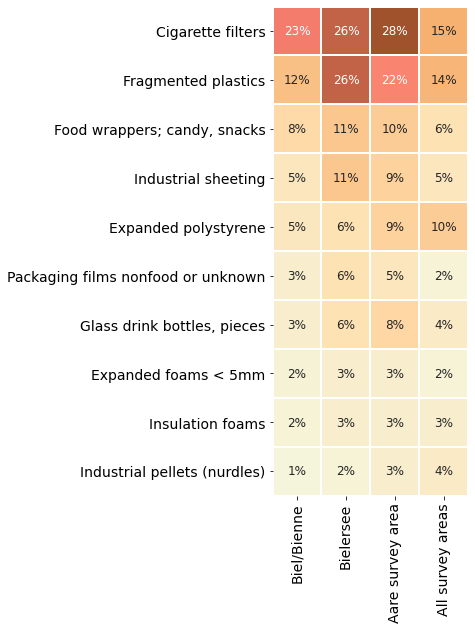

In [10]:
# chart that
fig, ax  = plt.subplots(figsize=(len(bsee.columns)*.9,len(bsee)*.9))
axone = ax

sns.heatmap(bsee, ax=axone, cmap=cmap2, annot=True, annot_kws={"fontsize":12}, fmt=".0%", square=True, cbar=False, linewidth=.1, linecolor='white')

axone.set_ylabel("")
axone.tick_params(labelsize=14, which='both', axis='both')

plt.setp(axone.get_xticklabels(), rotation=90)

plt.show()
plt.close()

### Discussion

There were 16 beach-litter surveys completed between April 2020 and May 2021 at three different locations in Biel/Bienne which permitted the identification of 3,067 objects. The most common objects from the Aare survey area account for 66% of all objects identified in Biel. Objects that are directly related to consumption (food, drinks, tobacco) are found at a rate that exceeds the median for the survey area, these objects represent $\approx$ 34% of the trash collected in Biel/Bienne compared to 25% for all survey areas.

Objects not directly related to consumption such as fragmented plastics, industrial sheeting, expanded polystyrene or industrial pellets are found at greater rates than the rest of the Aare survey area.  Expanded polystyrene is used as an exterior insulation envelope for buildings (new construction and renovations) and to protect component objects during transportation. Biel has a strong industrial base and an active construction and manufacturing base. Combined these objects represent 30% of the total number of objects collected.

#### Application

The key indicators are simple ratios taken directly from the survey results. Changes in the magnitude of those ratios signal changes in the relative quantity of specific objects. When the key indicators are used within the context of a monitoring program they permit to identify probable zones of accumulation.

### Practical exercise

Plastic industrial pellets (GPI) are the primary material used to produce plastic objects they are used extensively in Switzerland. They are disc or pellet shaped with a diameter of ~5mm.

Given the following survey results, the map of survey locations, and maintaining the assumptions presented at the beginning of this article answer the following questions:

1. Where are the best chances of finding at least one?
2. If a survey of 50 meters is conducted what is the probable minimum amount of pellets would you find?
3. Why did you pick that location or locations? How sure are you of your choices?

In [11]:
aggs = {'loc_date':'nunique', 'fail':'sum', 'pcs_m':'mean', "quantity":"sum"}
new_col_names = {"loc_date":"# of samples", "fail":"# fail", "pcs_m":"median pcs/m", "quantity":"#found"}

biel_g95 = dfSurveys[(dfSurveys.water_name_slug == levels['water_name_slug'])&(dfSurveys.code == 'G112')].groupby(['location']).agg(aggs)
biel_g95.rename(columns=new_col_names, inplace=True)

biel_g95

,# of samples,# fail,median pcs/m,#found
location,,,,
bielersee_vinelz_fankhausers,12,9,0.1275,22
camp-des-peches,1,0,0.0000,0
erlach-camping-strand,1,0,0.0000,0
gals-reserve,2,0,0.0000,0
ligerz-strand,2,0,0.0000,0
luscherz-plage,4,2,0.0150,3
luscherz-two,1,0,0.0000,0
mullermatte,12,9,0.0725,37
nidau-strand,1,1,0.0800,2


<br></br>

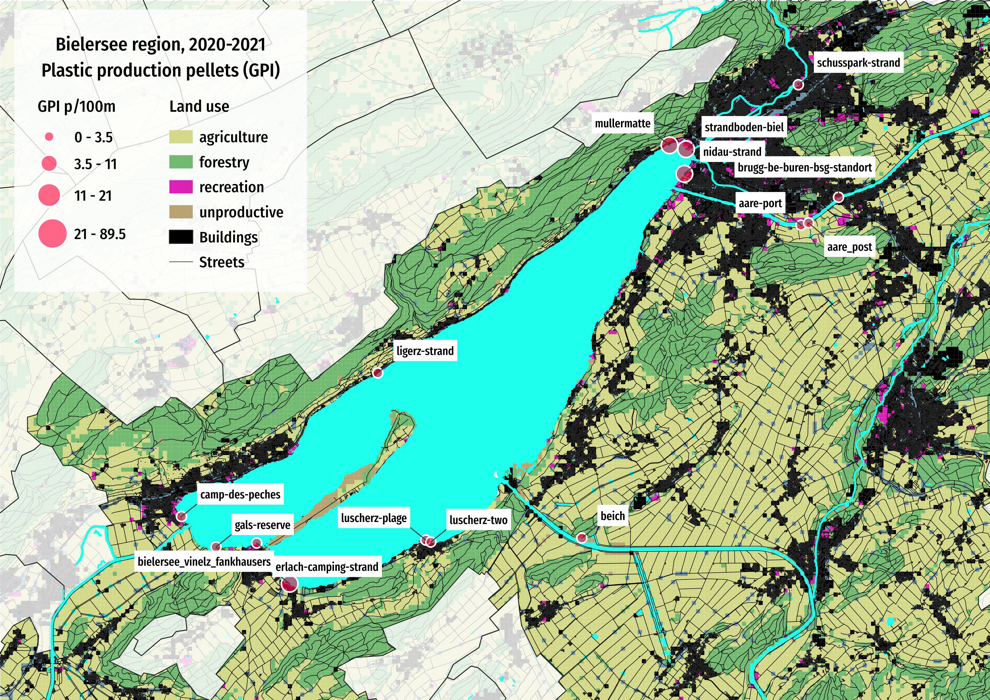

In [12]:
sut.display_image_ipython("resources/maps/key_indicators.jpeg", thumb=(1200, 700))